# Example of semantic segmentation

# 1. Set up kaggle

## 1.1 Install kaggle dependency

In [1]:
!pip install -q kaggle

## 1.2 Upload kaggle api through json file

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hahalim","key":"ce68a07f66f1bdfcaa4088307943d0e2"}'}

## 1.3 Create hidden directory at root directory and store the json file in the directory

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

## 1.4 Change the access permission of the api file

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

## 1.5 Test if the kaggle api is set up correctly

In [5]:
!kaggle datasets list

ref                                                            title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadehsan000/healthcare-dataset-2019-2024                  Healthcare Dataset (2019-2024)                    3MB  2024-08-09 17:52:25           3748         82  1.0              
berkayalan/paris-2024-olympics-medals                          Paris 2024 Olympics Medals                        1KB  2024-08-14 11:02:45           1652         36  1.0              
muhammadehsan000/olympic-games-medal-dataset-1994-2024         Olympic Games Medal Dataset (1994-2024)          17KB  2024-08-18 22:45:16            823         24  1.0              
myrios/cost-of-living-index-by-country-by-number-2024          Cost of Living Index b

## 2 Download the dataset
The dataset can be found [here](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset).

In [6]:
!kaggle datasets download -d tapakah68/segmentation-full-body-mads-dataset

Dataset URL: https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset
License(s): Attribution-NoDerivatives 4.0 International (CC BY-ND 4.0)
 99% 471M/475M [00:18<00:00, 30.2MB/s]
100% 475M/475M [00:18<00:00, 27.0MB/s]


Unzip the compressed folder downloaded.

In [7]:
!unzip -q segmentation-full-body-mads-dataset.zip

## 3 Data preprocessing

### 3.1 Identify all the image data file paths
It should be noted that what we want are just the raw image files and segmentation masks.

In [8]:
# find the image paths and store them in a list
import os
base_dir = "/content/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img"

img_dir = base_dir + "/images"
mask_dir = base_dir + "/masks"

input_img_paths = sorted([
    os.path.join(img_dir, fname)
    for fname in os.listdir(img_dir)
    if fname.endswith(".png")
])

target_mask_paths = sorted([
    os.path.join(mask_dir, fname)
    for fname in os.listdir(mask_dir)
    if fname.endswith(".png")
])

print(f"Number of samples of raw images: {len(input_img_paths)}.")
print(f"Number of samples of mask images: {len(target_mask_paths)}.")

Number of samples of raw images: 1192.
Number of samples of mask images: 1192.


In [9]:
for img, mask in zip(input_img_paths[:10], target_mask_paths[:10]):
    print(img + " | " + mask)

/content/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C0_00180.png | /content/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks/HipHop_HipHop1_C0_00180.png
/content/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C0_00225.png | /content/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks/HipHop_HipHop1_C0_00225.png
/content/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C0_00360.png | /content/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks/HipHop_HipHop1_C0_00360.png
/content/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C0_00405.png | /content/segmentation_full_body_mads_dataset_1192_img/seg

## 3.2 Visualization of image and its corresponding mask

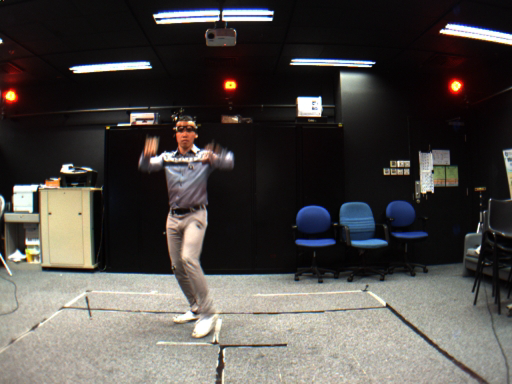

In [10]:
from IPython.display import Image

Image(input_img_paths[1])

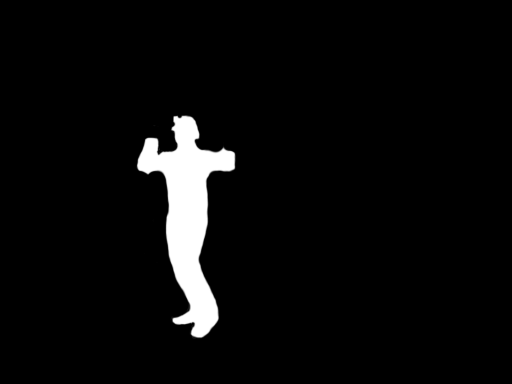

In [11]:
Image(target_mask_paths[1])

**Image augmentation visualization**

Proof of concept



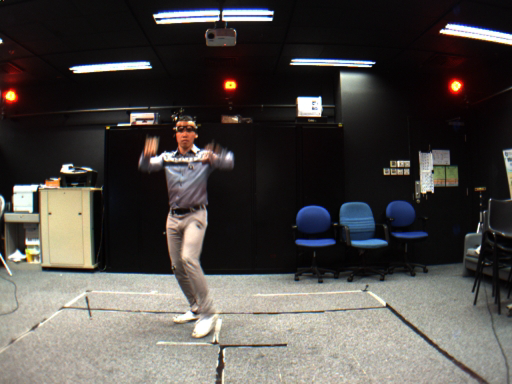

In [12]:
import tensorflow as tf

viz_image = tf.keras.preprocessing.image.load_img(input_img_paths[1])
viz_image

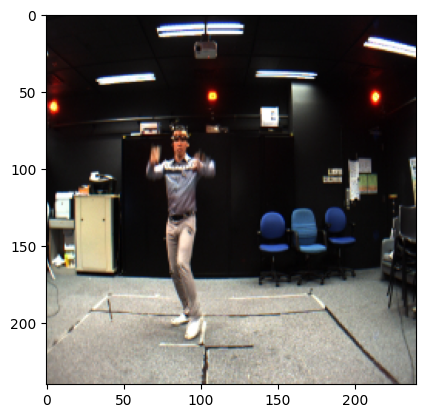

In [13]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 240

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

viz_image = np.array(viz_image)
viz_image = tf.convert_to_tensor(viz_image)
res = resize_and_rescale(viz_image)
_ = plt.imshow(res)

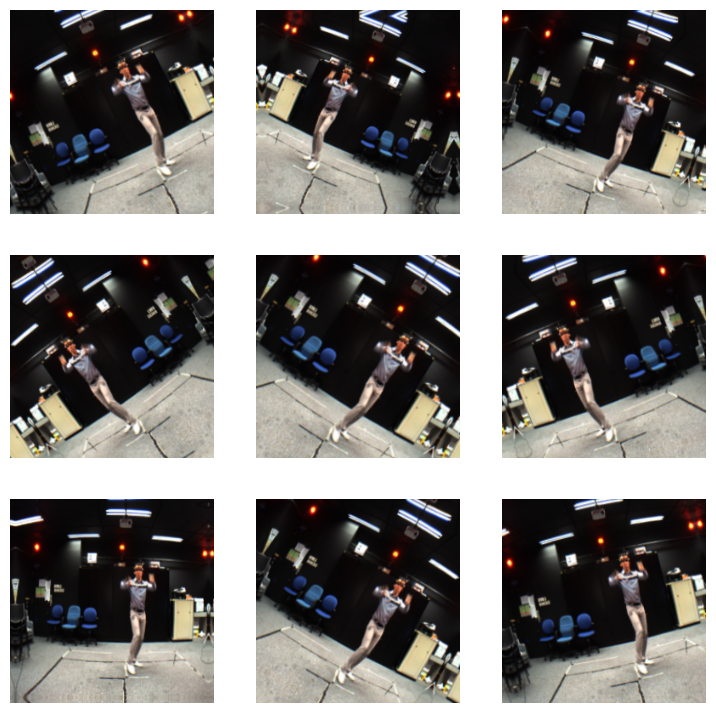

In [14]:
res1 = tf.expand_dims(res, 0)

plt.figure(figsize=(9, 9))
for i in range(9):
    augmented = data_augmentation(res1)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented[0])
    plt.axis("off")

## 3.3 Setup the image and mask loading function

In [15]:
# Import libraries
import keras
import numpy as np
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

# define a function to load the image files
def get_dataset(img_size,
                input_img_paths,
                target_mask_paths):
    """Function to retrieve tf.data.Dataset object"""
    def load_img_masks(input_img_path, target_mask_path):
        input_img = tf.io.read_file(input_img_path)
        input_img = tf.io.decode_png(input_img, channels=3)
        input_img = tf.image.resize(input_img, tf.constant([img_size, img_size]))

        target_mask = tf.io.read_file(target_mask_path)
        target_mask = tf.io.decode_png(target_mask, channels=1)
        target_mask = tf.image.resize(target_mask, tf.constant([img_size, img_size]), method="nearest")
        target_mask = tf.cast(target_mask > 0, tf.int32)

        return input_img, target_mask

    dataset = tf.data.Dataset.from_tensor_slices((input_img_paths, target_mask_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=AUTOTUNE)
    return dataset

In [16]:
BATCH_SIZE = 32
IMG_SIZE = 240

import random

# split into train, validation and test
val_samples = 200

random.Random(555).shuffle(input_img_paths)
random.Random(555).shuffle(target_mask_paths)
test_input_img_paths = input_img_paths[:val_samples]
test_target_mask_paths = target_mask_paths[:val_samples]
val_input_img_paths = input_img_paths[val_samples:(val_samples+val_samples)]
val_target_mask_paths = target_mask_paths[val_samples:(val_samples+val_samples)]
train_input_img_paths = input_img_paths[(val_samples+val_samples):]
train_target_mask_paths = target_mask_paths[(val_samples+val_samples):]

In [17]:
train_ds = get_dataset(IMG_SIZE, train_input_img_paths, train_target_mask_paths)
test_ds = get_dataset(IMG_SIZE, test_input_img_paths, test_target_mask_paths)
val_ds = get_dataset(IMG_SIZE, val_input_img_paths, val_target_mask_paths)

In [18]:
class Augment(layers.Layer):
    def __init__(self, seed=24):
        super().__init__()
        self.augment_inputs = tf.keras.Sequential([
            layers.RandomFlip("horizontal", seed=seed),
            layers.RandomRotation(0.2, seed=seed)
        ])
        self.augment_mask = tf.keras.Sequential([
            layers.RandomFlip("horizontal", seed=seed),
            layers.RandomRotation(0.2, seed=seed)
        ])

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_mask(labels)
        return inputs, labels

In [19]:
rescale = layers.Rescaling(1./127.5, offset=-1)

def prepare(ds, augment=False):
    # Rescale
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    # batch
    ds = ds.batch(BATCH_SIZE)
    # augmentation
    if augment:
        ds = ds.map(Augment())
    return ds.prefetch(buffer_size=AUTOTUNE)

In [20]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Visualize the dataset

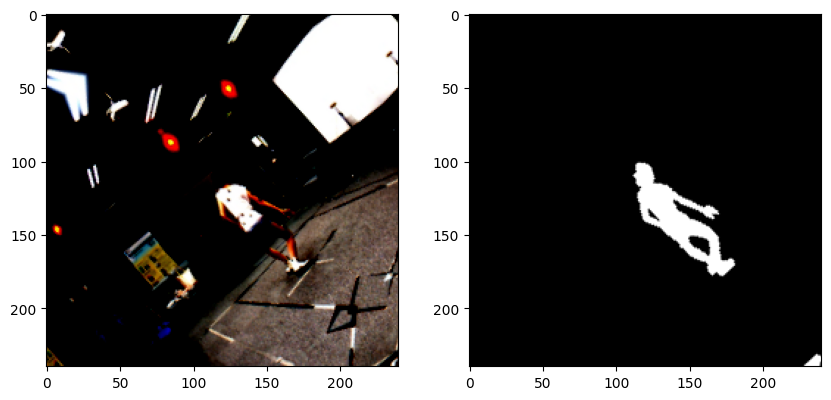

In [21]:
plt.figure(figsize=(10, 5))
for img, mask in train_ds:
    # print(img.shape)
    # print(mask.shape)
    plt.subplot(121)
    plt.imshow(tf.squeeze(img[0]))
    plt.subplot(122)
    plt.imshow(tf.squeeze(mask[0]), cmap="gray")
    break

# 4. Construct the model architecture

UNet

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation

class EncoderBlock(layers.Layer):
    def __init__(self, filters, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.pooling = pooling
        self.conv1 = Conv2D(filters, 3, padding="same", activation="relu")
        self.conv2 = Conv2D(filters, 3, padding="same", activation=None)
        self.bn = BatchNormalization()
        self.activation = Activation(tf.keras.activations.leaky_relu)
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.activation(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "pooling": self.pooling
        }

In [23]:
from tensorflow.keras.layers import UpSampling2D, concatenate

class Decoder(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(Decoder, self).__init__(**kwargs)

        self.filters = filters
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters
        }

## Construct the UNET model

In [24]:
from tensorflow import keras
# inputs
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Encoder (p is downsampled feature map, c is for concatenation)
p1, c1 = EncoderBlock(32, name="encoder_1")(inputs)
p2, c2 = EncoderBlock(64, name="encoder_2")(p1)
p3, c3 = EncoderBlock(128, name="encoder_3")(p2)
p4, c4 = EncoderBlock(256, name="encoder_4")(p3)

# bottleneck
bottleneck = Conv2D(512, 1, activation="leaky_relu", use_bias=False)(p4)

# decoder
d1 = Decoder(256, name="decoder_1")([bottleneck, c4])
d2 = Decoder(128, name="decoder_2")([d1, c3])
d3 = Decoder(64, name="decoder_3")([d2, c2])
d4 = Decoder(32, name="decoder_4")([d3, c1])

# output layer
output = Conv2D(1, kernel_size=1, activation="sigmoid", padding="same")(d4)

model = keras.Model(inputs, output)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder_block_2', however the layer

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 240, 240, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_1 (EncoderBlock)  │ [(None, 120, 120, 32), │         10,272 │ input_layer_4[0][0]    │
│                           │ (None, 240, 240, 32)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_2 (EncoderBlock)  │ [(None, 60, 60, 64),   │         55,680 │ encoder_1[0][0]        │
│                           │ (None, 120, 120, 64)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_3 (EncoderBlock)  │ [(None, 30, 30, 128),  │        221,952 │ encoder_2[0][0]        │
│                           │ (None, 60, 60, 128)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_4 (EncoderBlock)  │ [(None, 15, 15, 256),  │        886,272 │ encoder_3[0][0]        │
│                           │ (None, 30, 30, 256)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 15, 15, 512)    │        131,072 │ encoder_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_1 (Decoder)       │ (None, 30, 30, 256)    │      2,360,832 │ conv2d_8[0][0],        │
│                           │                        │                │ encoder_4[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_2 (Decoder)       │ (None, 60, 60, 128)    │        590,592 │ decoder_1[0][0],       │
│                           │                        │                │ encoder_3[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_3 (Decoder)       │ (None, 120, 120, 64)   │        147,840 │ decoder_2[0][0],       │
│                           │                        │                │ encoder_2[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_4 (Decoder)       │ (None, 240, 240, 32)   │         37,056 │ decoder_3[0][0],       │
│                           │                        │                │ encoder_1[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 240, 240, 1)    │             33 │ decoder_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,441,601 (16.94 MB)

 Trainable params: 4,439,681 (16.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

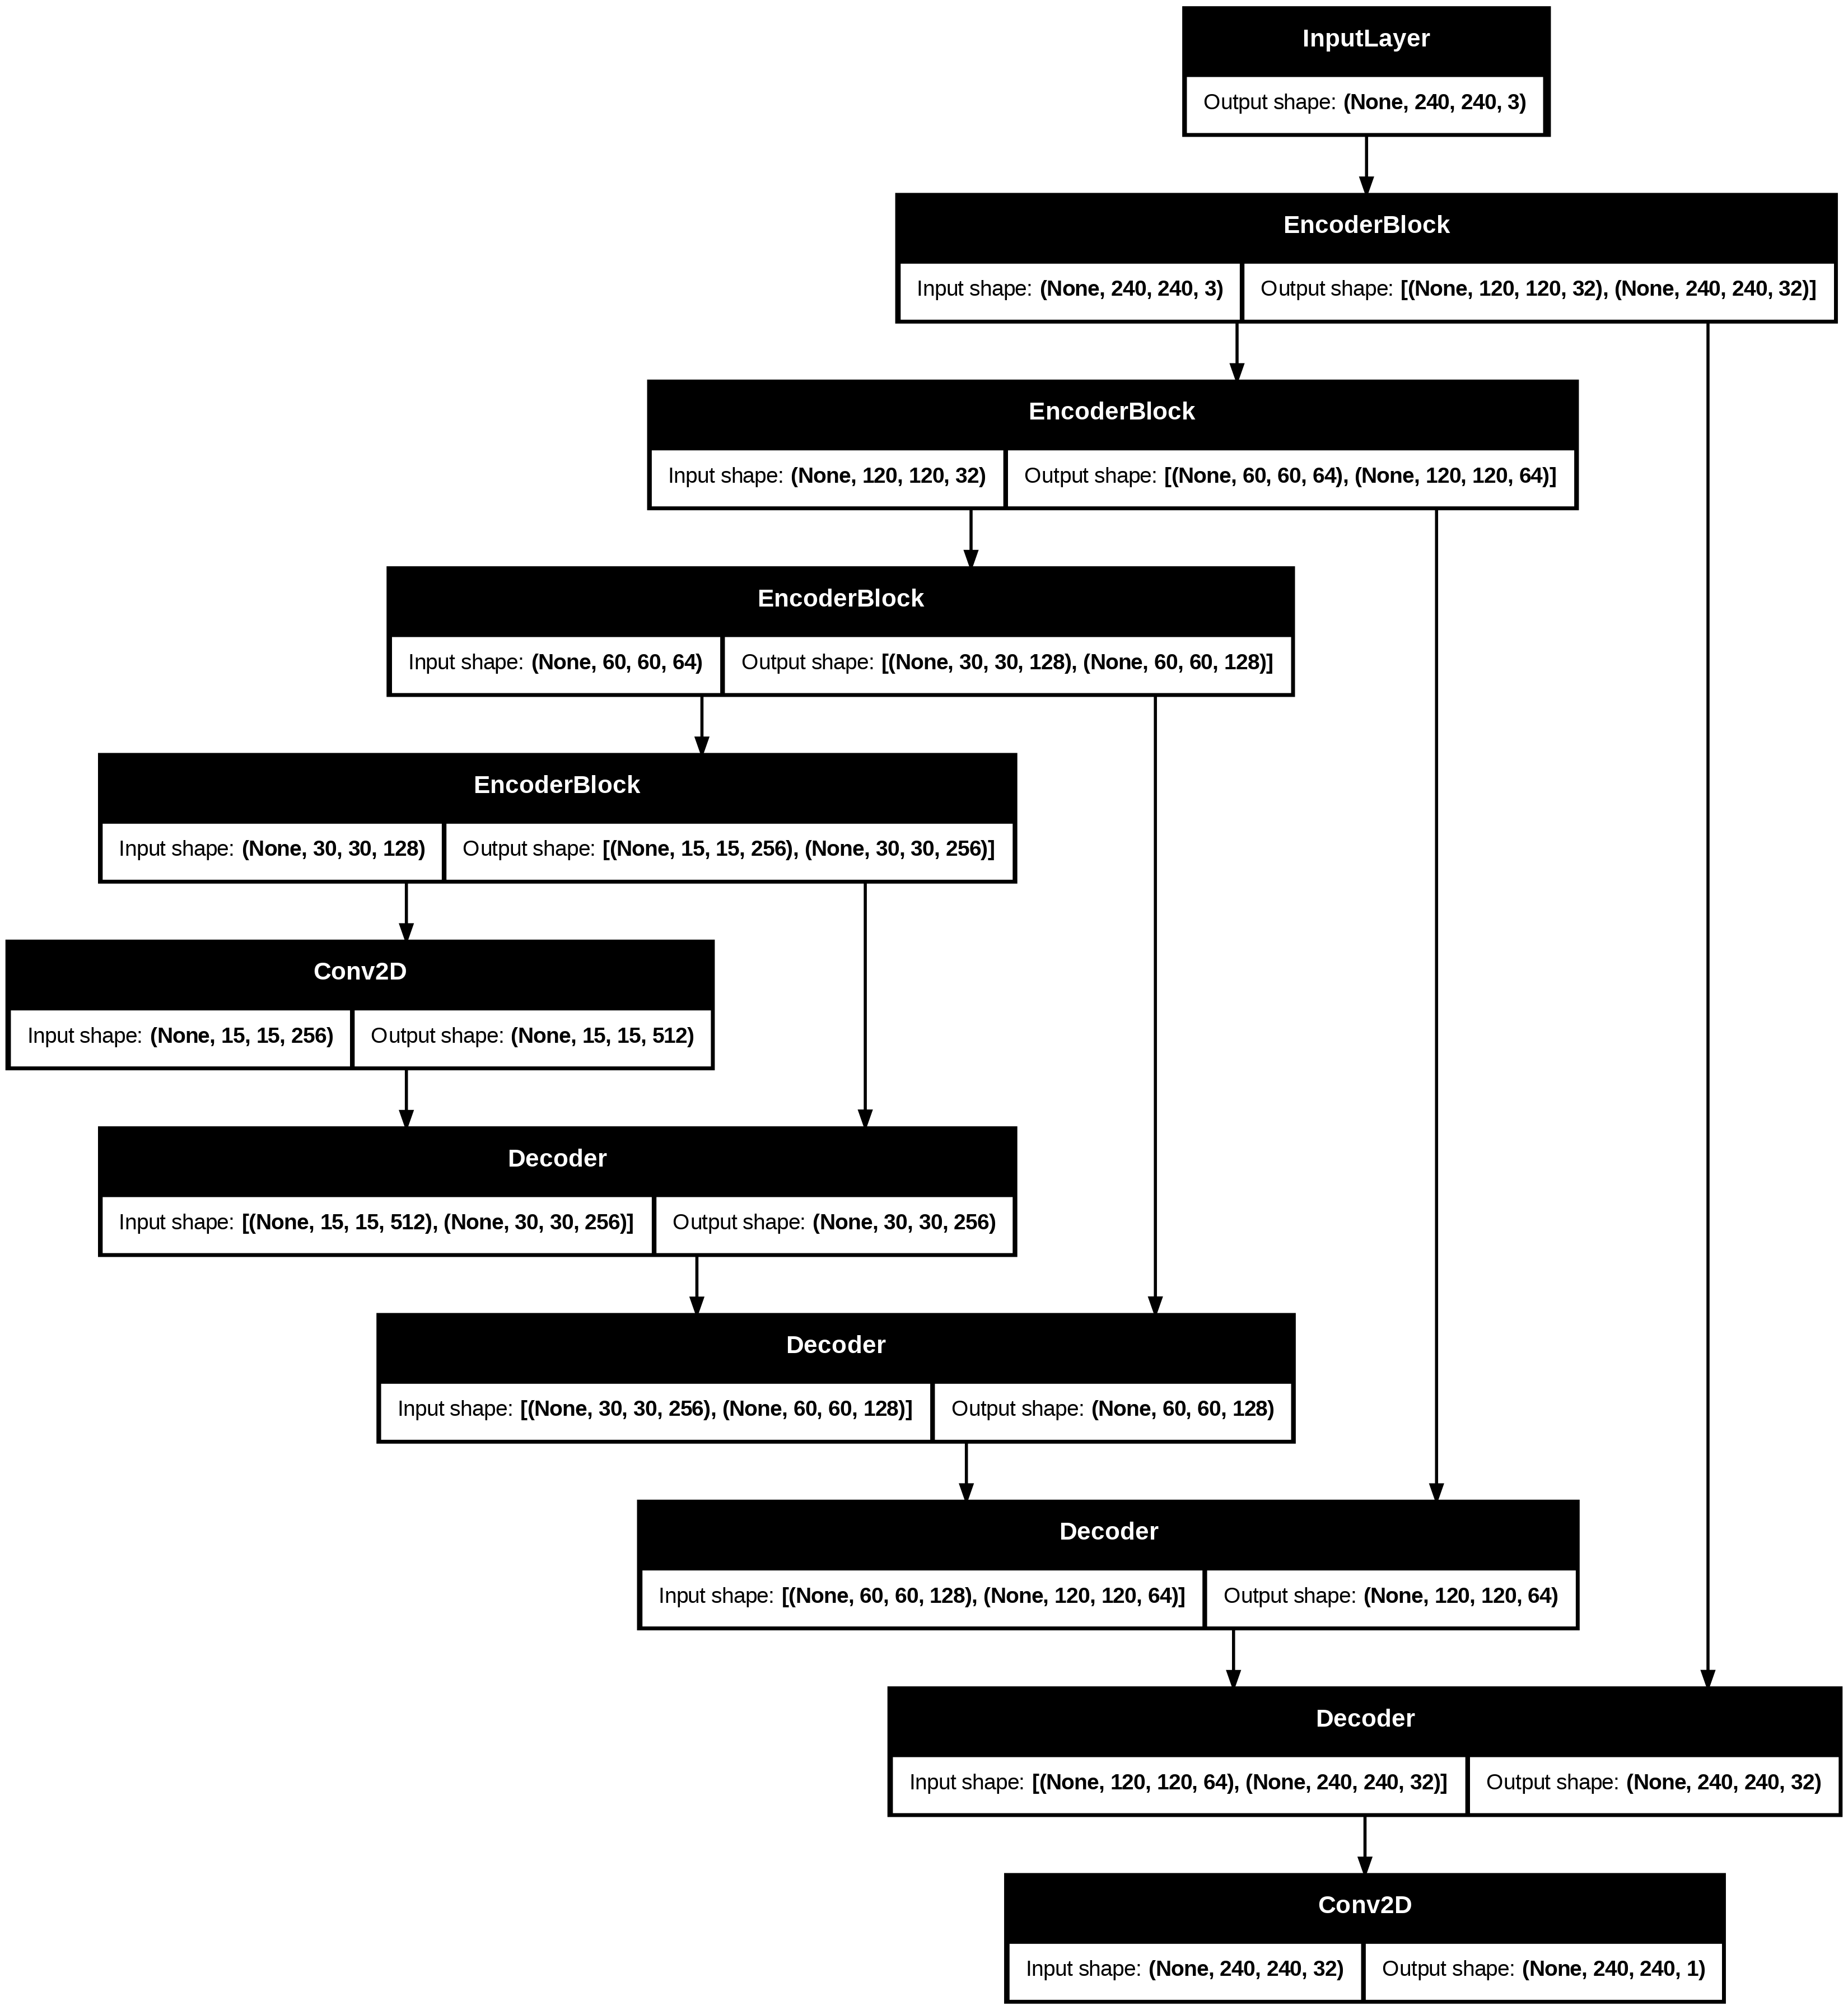

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="human_seg_unet.png", show_shapes=True)

### Learning rate scheduler

In [26]:
# import tensorflow as tf
# from tensorflow import keras

# define learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.005
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr * pow(epoch, -0.5)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
# IOU function
# from tensorflow.keras import backend as K

# def IOU_metric(y_true, y_pred, smooth=1):
#     y_true = K.flatten(y_true)
#     y_pred = K.flatten(y_pred)
#     intersection = tf.math.reduce_sum(y_true * y_pred)
#     denom = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) - intersection + smooth
#     return (intersection + smooth) / denom

In [28]:
# compile the model
es_callback = keras.callbacks.EarlyStopping(patience=5)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.metrics.BinaryAccuracy(), tf.keras.metrics.BinaryIoU()]
)

In [29]:
epoch = 30

history = model.fit(
    train_ds,
    epochs=epoch,
    callbacks=[lr_scheduler, es_callback],
    validation_data=val_ds,
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - binary_accuracy: 0.7028 - binary_io_u: 0.3526 - loss: 0.5864 - val_binary_accuracy: 0.9531 - val_binary_io_u: 0.4765 - val_loss: 457.0302 - learning_rate: 0.0050
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 905ms/step - binary_accuracy: 0.9489 - binary_io_u: 0.5213 - loss: 0.1844 - val_binary_accuracy: 0.9530 - val_binary_io_u: 0.4765 - val_loss: 1.5194 - learning_rate: 0.0050
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 897ms/step - binary_accuracy: 0.9630 - binary_io_u: 0.7011 - loss: 0.1066 - val_binary_accuracy: 0.9519 - val_binary_io_u: 0.4804 - val_loss: 0.3641 - learning_rate: 0.0050
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 847ms/step - binary_accuracy: 0.9715 - binary_io_u: 0.7717 - loss: 0.0720 - val_binary_accuracy: 0.9568 - val_binary_io_u: 0.5826 - val_loss: 0.1561 - learning_rate: 0.0050
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 882ms/step - binary_accuracy: 0.9749 - binary_io_u: 0.7996 - loss: 0.0584 - val_binary_accuracy: 0

### Learning curve

In [30]:
history.history["binary_io_u"]

[0.3814757466316223,
 0.5650174021720886,
 0.7077977061271667,
 0.7669155597686768,
 0.8008159399032593,
 0.8432763814926147,
 0.864026665687561,
 0.871727466583252,
 0.8765707015991211,
 0.8794626593589783,
 0.885177493095398,
 0.8882511854171753]

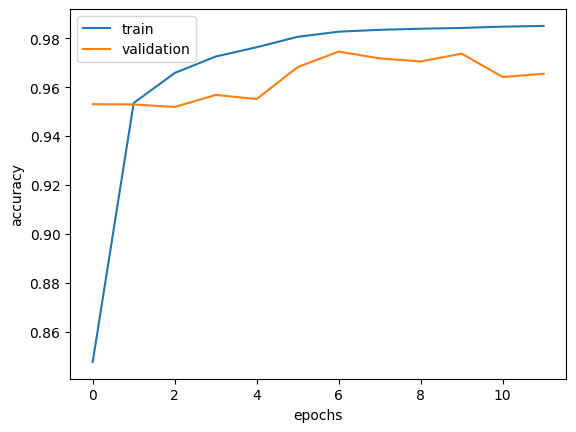

In [32]:
def plot_learning_curve(hist, mode="acc"):
    if mode=="acc":
        plt.plot(hist.history["binary_accuracy"], label="train")
        plt.plot(hist.history["val_binary_accuracy"], label="validation")
        plt.ylabel("accuracy")
    elif mode=="iou":
        plt.plot(hist.history["binary_io_u"], label="train")
        plt.plot(hist.history["val_binary_io_u"], label="validation")
        plt.ylabel("IOU")
    elif mode=="loss":
        plt.plot(hist.history["loss"], label="train")
        plt.plot(hist.history["val_loss"], label="validation")
        plt.ylabel("Loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

plot_learning_curve(history)

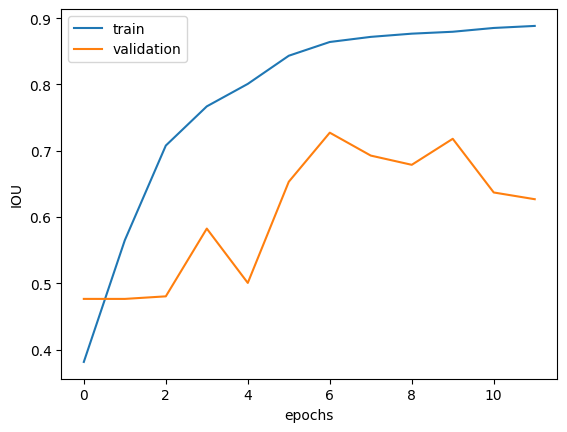

In [33]:
plot_learning_curve(history, mode="iou")

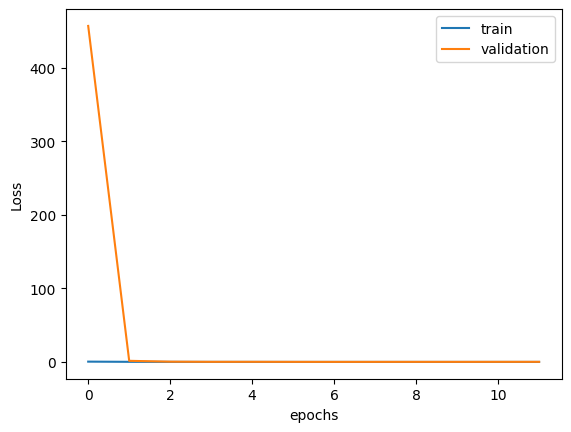

In [34]:
plot_learning_curve(history, mode="loss")

## Model evaluation

In [35]:
scores = model.evaluate(test_ds)
scores

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - binary_accuracy: 0.9529 - binary_io_u: 0.5851 - loss: 0.2164


[0.22823932766914368, 0.9506943225860596, 0.5809494256973267]

## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


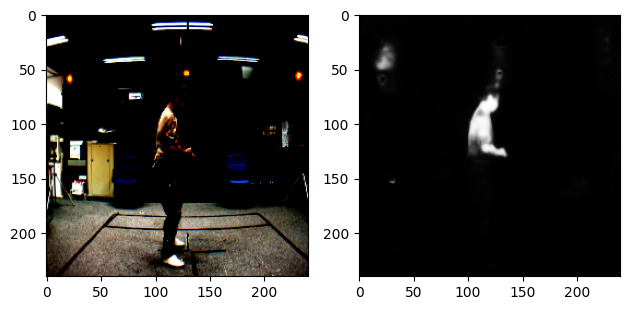

In [38]:
# Take an image
for imgs, _ in test_ds.take(1):
    img = imgs[0]

img = tf.expand_dims(img, 0)
seg_mask = model.predict(img)

plt.subplot(121)
plt.imshow(tf.squeeze(img))
plt.subplot(122)
plt.imshow(tf.squeeze(seg_mask), cmap="gray")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


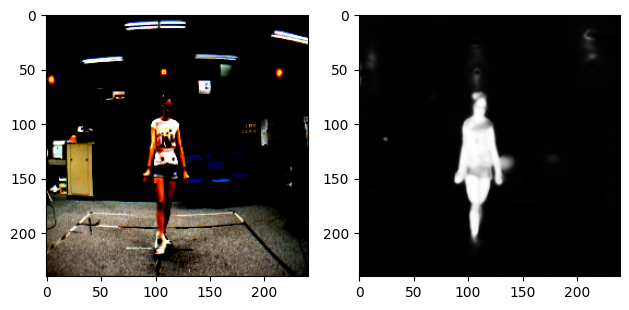

In [39]:
for imgs, _ in test_ds.take(2):
    img = imgs[0]

img = tf.expand_dims(img, 0)
seg_mask = model.predict(img)

plt.subplot(121)
plt.imshow(tf.squeeze(img))
plt.subplot(122)
plt.imshow(tf.squeeze(seg_mask), cmap="gray")
plt.tight_layout()
plt.show()